In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/TCC/SPIE-AAPM-LungCT.zip

In [ ]:
!ls SPIE-AAPM-LungCT/test

benign	malignant


In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.3 MB/s eta 0:00:00


In [ ]:
!mkdir dataset
!mkdir dataset/benign
!mkdir dataset/malignant

In [ ]:
from PIL import Image
import pydicom
import os
import numpy as np

def get_names(path):
    names = []
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            _, ext = os.path.splitext(filename)
            if ext in ['.dcm']:
                names.append(filename)
    
    return names

def convert_dcm_jpg(name, scope):
    im = pydicom.dcmread(f'SPIE-AAPM-LungCT/test/{scope}/{name}')

    im = im.pixel_array.astype(float)

    rescaled_image = (np.maximum(im,0)/im.max())*255 # float pixels
    final_image = np.uint8(rescaled_image) # integers pixels

    final_image = Image.fromarray(final_image)

    return final_image

names = get_names('SPIE-AAPM-LungCT/test/benign')

for name in names:
    image = convert_dcm_jpg(name, "benign")
    image.save(f"dataset/benign/{name.replace('dcm', 'jpg')}")

names = get_names('SPIE-AAPM-LungCT/test/malignant')

for name in names:
    image = convert_dcm_jpg(name, "malignant")
    image.save(f"dataset/malignant/{name.replace('dcm', 'jpg')}")

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

train_ds.class_names

Found 19084 files belonging to 2 classes.
Using 15268 files for training.
Found 19084 files belonging to 2 classes.
Using 3816 files for validation.


['benign', 'malignant']

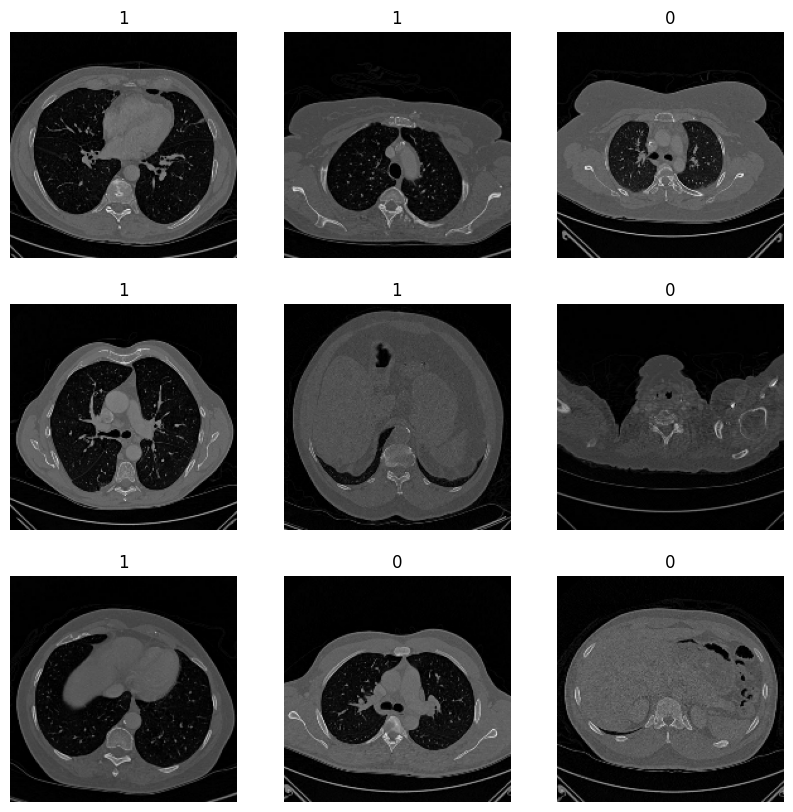

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

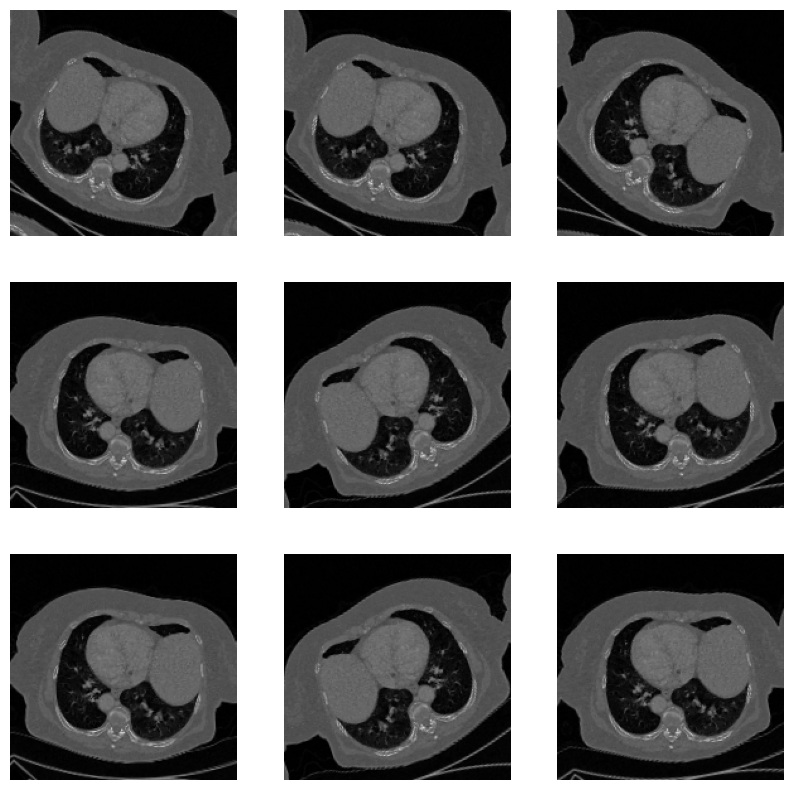

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
input_shape = (50,50,3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model

Ellipsis

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

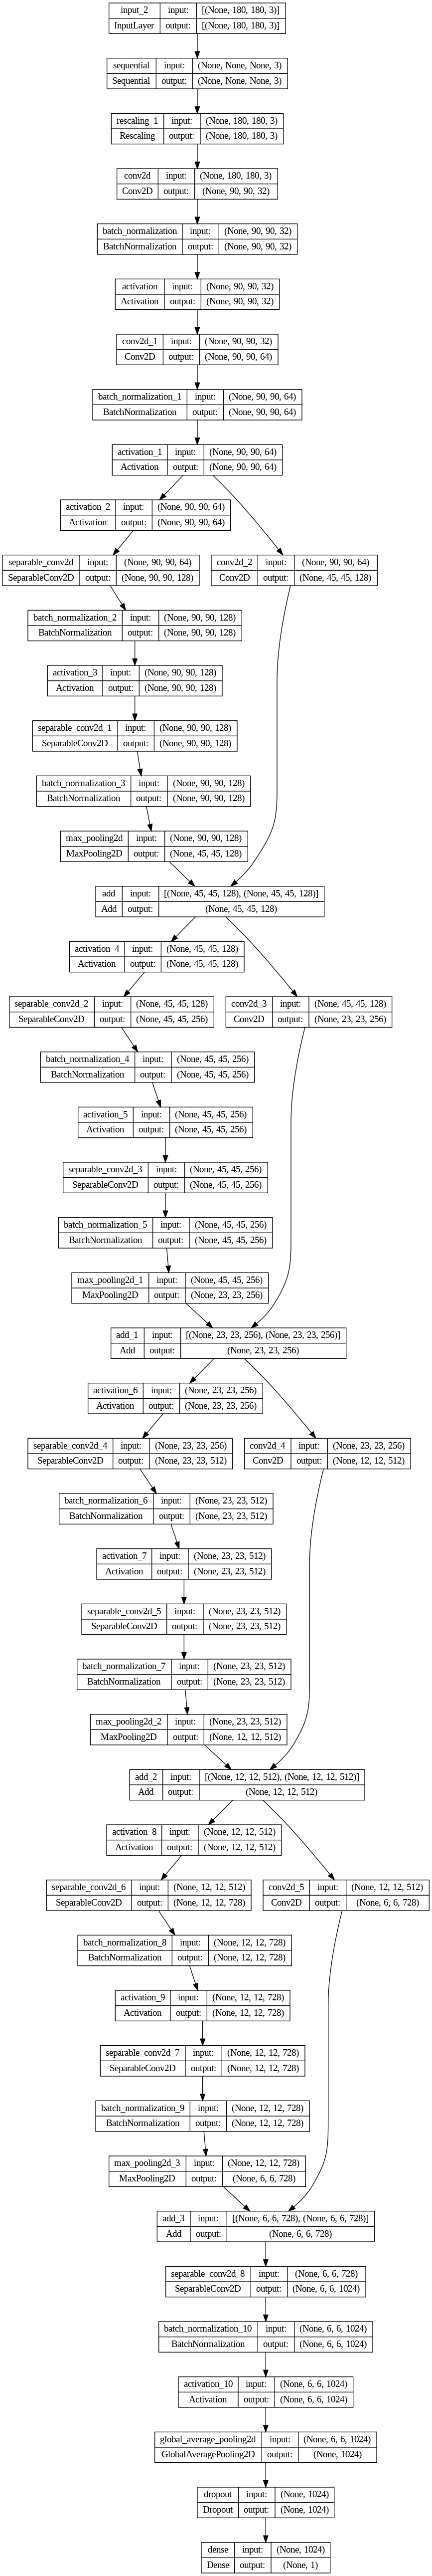

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [17]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
478/478 [==============================] - 114s 179ms/step - loss: 0.6083 - accuracy: 0.6657 - val_loss: 0.6587 - val_accuracy: 0.6268
Epoch 2/50
478/478 [==============================] - 84s 176ms/step - loss: 0.4448 - accuracy: 0.7864 - val_loss: 0.7472 - val_accuracy: 0.7432
Epoch 3/50
478/478 [==============================] - 84s 176ms/step - loss: 0.3241 - accuracy: 0.8550 - val_loss: 0.9642 - val_accuracy: 0.7227
Epoch 4/50
478/478 [==============================] - 86s 178ms/step - loss: 0.2221 - accuracy: 0.9069 - val_loss: 0.2392 - val_accuracy: 0.9122
Epoch 5/50
478/478 [==============================] - 84s 176ms/step - loss: 0.1699 - accuracy: 0.9314 - val_loss: 0.8646 - val_accuracy: 0.7487
Epoch 6/50
478/478 [==============================] - 85s 178ms/step - loss: 0.1321 - accuracy: 0.9478 - val_loss: 0.1774 - val_accuracy: 0.9413
Epoch 7/50
478/478 [==============================] - 86s 178ms/step - loss: 0.0961 - accuracy: 0.9639 - val_loss: 1.7020 - val_a

In [18]:
img = keras.preprocessing.image.load_img(
    "dataset/benign/011-001.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent benign and %.2f percent malignant."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 2s 2s/step
This image is 99.99 percent benign and 0.01 percent malignant.


In [19]:
img = keras.preprocessing.image.load_img(
    "dataset/malignant/011-001.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent benign and %.2f percent malignant."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 42ms/step
This image is 0.00 percent benign and 100.00 percent malignant.
